# 🤖 Credit Score Simulator – Modeling & Evaluation

## Objective

This notebook focuses on building and evaluating machine learning models to predict whether a customer will experience **serious delinquency** (90+ days overdue) within the next two years.

The goal is to:

- Train and evaluate baseline models
- Handle class imbalance
- Tune hyperparameters for performance
- Compare metrics (precision, recall, F1-score, AUC)
- Select a final model for deployment

To ensure reproducibility and avoid data leakage, all preprocessing and feature engineering were completed in the previous notebook. Scaling and modeling will be performed using pipelines in this notebook.

---

## Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt


## Load Dataset

The dataset `df_cleaned.csv` contains:

- Selected original features
- Engineered features created from domain logic
- **Unscaled numeric values**, allowing for clean integration into model pipelines
- The target variable: `SeriousDlqin2yrs` (0 = No Default, 1 = Default)

In [2]:
# Load the cleaned dataset
df = pd.read_csv("../data/df_cleaned.csv")  # Ajusta ruta si es necesario

# Preview
df.head()


,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,MonthlyIncome,NumberOfDependents,TotalPastDue,FinancialStressScore,CreditBurdenPerLine,AgeUtilizationRatio,IncomeAgeRatio,LinesPerYear
0,1,0.766127,45,2,0.802982,13,0,6,0,9120.0,2.0,2,0.615186,651.428571,57.980231,198.260870,0.282609
1,0,0.957151,40,0,0.121876,4,0,0,0,2600.0,1.0,0,0.116654,520.000000,41.358587,63.414634,0.097561
2,0,0.658180,38,1,0.085113,2,1,0,0,3042.0,0.0,2,0.056020,1014.000000,56.870891,78.000000,0.051282
3,0,0.233810,30,0,0.036050,5,0,0,0,3300.0,0.0,0,0.008429,550.000000,123.046748,106.451613,0.161290
4,0,0.907239,49,1,0.024926,7,0,1,0,23011.9,0.0,1,0.022614,2876.487500,53.421168,460.238000,0.140000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147610 entries, 0 to 147609
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeriousDlqin2yrs      147610 non-null  int64  
 1   RevolvingUtilization  147610 non-null  float64
 2   age                   147610 non-null  int64  
 3   Times30_59DaysLate    147610 non-null  int64  
 4   DebtToIncomeRatio     147610 non-null  float64
 5   OpenCreditLines       147610 non-null  int64  
 6   Times90DaysLate       147610 non-null  int64  
 7   RealEstateLoans       147610 non-null  int64  
 8   Times60_89DaysLate    147610 non-null  int64  
 9   MonthlyIncome         147610 non-null  float64
 10  NumberOfDependents    147610 non-null  float64
 11  TotalPastDue          147610 non-null  int64  
 12  FinancialStressScore  147610 non-null  float64
 13  CreditBurdenPerLine   147610 non-null  float64
 14  AgeUtilizationRatio   147610 non-null  float64
 15  

In [4]:
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93327
1    0.06673
Name: proportion, dtype: float64

## Train/Validation/Test Split

To ensure reliable model evaluation and avoid data leakage, the dataset is split into three subsets:

- **Training set (80%)** – Used to fit and train the model
- **Test set (20%)** – Held out until final evaluation to assess generalization on unseen data

The splits are performed using `train_test_split` with stratification to maintain the same proportion of the target variable (`SeriousDlqin2yrs`) across all subsets.


In [5]:
X = df.drop(columns="SeriousDlqin2yrs")
y = df["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train:      {X_train.shape}")
print(f"Test:       {X_test.shape}")


Train:      (118088, 16)
Test:       (29522, 16)


## Best Model Selection
To compare the performance of several baseline models, a consistent training and evaluation pipeline was implemented. This approach ensured that all models were assessed under the same preprocessing and validation conditions, allowing for a fair and reliable comparison.

- **Models trained**: Logistic Regression, Random Forest, XGBoost, and LightGBM  
- **Validation strategy**: 5-fold Stratified Cross-Validation to preserve class distribution across folds  
- **Preprocessing steps within each fold**:  
  - Feature scaling to normalize the input variables  
  - Class balancing using SMOTE to address target imbalance  
- **Evaluation metrics**:  
  - AUC (Area Under the ROC Curve)  
  - F1-score  
  - Precision  
  - Recall  
- **Performance recording**: Mean metric values were calculated across the five folds for each model  
- **Purpose**: To ensure a standardized and fair comparison of model performance across all candidates



In [11]:
# Define models with basic hyperparameters 
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
}

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store results
results = []

# Evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}")
    aucs, f1s, precisions, recalls = [], [], [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold_raw, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold_raw, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        # Scale training and validation separately to avoid leakage
        scaler = MinMaxScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold_raw)
        X_val_fold_scaled = scaler.transform(X_val_fold_raw)

        # Apply SMOTE on the scaled training fold
        smote = SMOTE(random_state=42)
        X_train_fold, y_train_fold = smote.fit_resample(X_train_fold_scaled, y_train_fold)

        # Fit model and evaluate
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold_scaled)
        y_prob = model.predict_proba(X_val_fold_scaled)[:, 1]

        aucs.append(roc_auc_score(y_val_fold, y_prob))
        f1s.append(f1_score(y_val_fold, y_pred))
        precisions.append(precision_score(y_val_fold, y_pred))
        recalls.append(recall_score(y_val_fold, y_pred))

    # Store average CV metrics + test metrics
    results.append({
        'Model': model_name,
        'CV AUC': np.mean(aucs),
        'CV AUC std': np.std(aucs),
        'CV F1': np.mean(f1s),
        'CV Precision': np.mean(precisions),
        'CV Recall': np.mean(recalls),
    })

# Show results
results_df = pd.DataFrame(results)
results_df


Training LogisticRegression
Training RandomForest
Training XGBoost
Training LightGBM


,Model,CV AUC,CV AUC std,CV F1,CV Precision,CV Recall
0,LogisticRegression,0.853608,0.005832,0.330725,0.212395,0.746954
1,RandomForest,0.829648,0.005805,0.344192,0.418764,0.292259
2,XGBoost,0.843237,0.004741,0.323891,0.455941,0.251269
3,LightGBM,0.854651,0.006593,0.363608,0.483998,0.291371


## Hyperparameters Search for the Best Model
To improve the performance of the best baseline model, hyperparameter tuning was conducted using Optuna. LightGBM, identified as the top-performing model, was optimized by maximizing its average AUC score across stratified folds while maintaining consistent preprocessing.

- **Model optimized**: LightGBM (selected as the best performer from baseline models)  
- **Optimization method**: Optuna, an efficient hyperparameter optimization framework  
- **Objective**: Maximize the average AUC score across 5 Stratified K-Folds  
- **Hyperparameters explored**:  
  - `n_estimators`  
  - `learning_rate`  
  - `max_depth`  
  - `num_leaves`  
  - Other relevant parameters  
- **Preprocessing within each fold**:  
  - Feature scaling  
  - Class balancing using SMOTE  
  - Ensured no data leakage during training and evaluation  
- **Outcome**: The best hyperparameter set identified by Optuna was used to retrain the final LightGBM model


In [12]:
# Objective function for Optuna
def objective(trial):
    try:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 2 ** trial.suggest_int('num_leaves_power', 5, 7)),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity':-1,
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []

        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

            # Scale separately to avoid data leakage
            scaler = MinMaxScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # Apply SMOTE only on training fold
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold_scaled, y_train_fold)

            # Train and evaluate
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_resampled, y_train_resampled)

            y_val_prob = model.predict_proba(X_val_fold_scaled)[:, 1]
            auc = roc_auc_score(y_val_fold, y_val_prob)

            # Validate AUC
            if np.isnan(auc) or np.isinf(auc):
                return float('-inf')
            aucs.append(auc)

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        print(f"[Trial {trial.number}] AUCs: {['{:.4f}'.format(a) for a in aucs]} | Mean AUC: {mean_auc:.4f} | Std: {std_auc:.4f}")

        return mean_auc

    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-05-18 23:09:42,681] A new study created in memory with name: no-name-97c362c4-e4f7-4b8f-9386-c81c9912bd7b
[I 2025-05-18 23:09:47,847] Trial 0 finished with value: 0.8520187957109757 and parameters: {'n_estimators': 76, 'learning_rate': 0.015026831215662768, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 26, 'subsample': 0.7752959114334187, 'colsample_bytree': 0.853544842772741}. Best is trial 0 with value: 0.8520187957109757.


[Trial 0] AUCs: ['0.8430', '0.8517', '0.8540', '0.8628', '0.8486'] | Mean AUC: 0.8520 | Std: 0.0065


[I 2025-05-18 23:09:56,535] Trial 1 finished with value: 0.8489618696695299 and parameters: {'n_estimators': 218, 'learning_rate': 0.22335774223149255, 'max_depth': 5, 'num_leaves_power': 7, 'num_leaves': 27, 'min_child_samples': 15, 'subsample': 0.8852306284137574, 'colsample_bytree': 0.9634807007231349}. Best is trial 0 with value: 0.8520187957109757.


[Trial 1] AUCs: ['0.8424', '0.8519', '0.8502', '0.8586', '0.8417'] | Mean AUC: 0.8490 | Std: 0.0063


[I 2025-05-18 23:10:04,468] Trial 2 finished with value: 0.8542326252394725 and parameters: {'n_estimators': 188, 'learning_rate': 0.031474998889571684, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 17, 'subsample': 0.8309418575807702, 'colsample_bytree': 0.6178361353218947}. Best is trial 2 with value: 0.8542326252394725.


[Trial 2] AUCs: ['0.8483', '0.8529', '0.8547', '0.8658', '0.8495'] | Mean AUC: 0.8542 | Std: 0.0062


[I 2025-05-18 23:10:16,665] Trial 3 finished with value: 0.855558797694551 and parameters: {'n_estimators': 278, 'learning_rate': 0.010710915864361773, 'max_depth': 5, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 19, 'subsample': 0.9393182803225159, 'colsample_bytree': 0.8295157154511585}. Best is trial 3 with value: 0.855558797694551.


[Trial 3] AUCs: ['0.8496', '0.8563', '0.8565', '0.8656', '0.8497'] | Mean AUC: 0.8556 | Std: 0.0059


[I 2025-05-18 23:10:24,809] Trial 4 finished with value: 0.85498733735208 and parameters: {'n_estimators': 136, 'learning_rate': 0.011382405361970088, 'max_depth': 6, 'num_leaves_power': 7, 'num_leaves': 126, 'min_child_samples': 11, 'subsample': 0.9628734872896909, 'colsample_bytree': 0.692621272274061}. Best is trial 3 with value: 0.855558797694551.


[Trial 4] AUCs: ['0.8493', '0.8548', '0.8562', '0.8651', '0.8497'] | Mean AUC: 0.8550 | Std: 0.0057


[I 2025-05-18 23:10:31,095] Trial 5 finished with value: 0.8494392509011724 and parameters: {'n_estimators': 109, 'learning_rate': 0.13291644535328637, 'max_depth': 7, 'num_leaves_power': 7, 'num_leaves': 78, 'min_child_samples': 27, 'subsample': 0.979205023207037, 'colsample_bytree': 0.9394678437282291}. Best is trial 3 with value: 0.855558797694551.


[Trial 5] AUCs: ['0.8433', '0.8487', '0.8477', '0.8621', '0.8453'] | Mean AUC: 0.8494 | Std: 0.0066


[I 2025-05-18 23:10:48,534] Trial 6 finished with value: 0.8540423565135133 and parameters: {'n_estimators': 230, 'learning_rate': 0.013136445694510487, 'max_depth': 9, 'num_leaves_power': 7, 'num_leaves': 108, 'min_child_samples': 27, 'subsample': 0.6399367851539234, 'colsample_bytree': 0.7825011810177903}. Best is trial 3 with value: 0.855558797694551.


[Trial 6] AUCs: ['0.8470', '0.8551', '0.8544', '0.8653', '0.8484'] | Mean AUC: 0.8540 | Std: 0.0065


[I 2025-05-18 23:10:54,868] Trial 7 finished with value: 0.8523305312452173 and parameters: {'n_estimators': 76, 'learning_rate': 0.06846145494322228, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 95, 'min_child_samples': 10, 'subsample': 0.8354633941602211, 'colsample_bytree': 0.6717845452149195}. Best is trial 3 with value: 0.855558797694551.


[Trial 7] AUCs: ['0.8460', '0.8535', '0.8520', '0.8645', '0.8456'] | Mean AUC: 0.8523 | Std: 0.0068


[I 2025-05-18 23:11:00,938] Trial 8 finished with value: 0.8550394899011773 and parameters: {'n_estimators': 159, 'learning_rate': 0.0215601218359651, 'max_depth': 3, 'num_leaves_power': 6, 'num_leaves': 21, 'min_child_samples': 22, 'subsample': 0.7757413562980819, 'colsample_bytree': 0.9102676681504888}. Best is trial 3 with value: 0.855558797694551.


[Trial 8] AUCs: ['0.8488', '0.8564', '0.8563', '0.8640', '0.8497'] | Mean AUC: 0.8550 | Std: 0.0055


[I 2025-05-18 23:11:05,346] Trial 9 finished with value: 0.8537357428716306 and parameters: {'n_estimators': 53, 'learning_rate': 0.022278919416534666, 'max_depth': 6, 'num_leaves_power': 7, 'num_leaves': 65, 'min_child_samples': 20, 'subsample': 0.8304150609714834, 'colsample_bytree': 0.9273524195815676}. Best is trial 3 with value: 0.855558797694551.


[Trial 9] AUCs: ['0.8487', '0.8526', '0.8553', '0.8639', '0.8482'] | Mean AUC: 0.8537 | Std: 0.0057


[I 2025-05-18 23:11:15,560] Trial 10 finished with value: 0.8536840630801248 and parameters: {'n_estimators': 300, 'learning_rate': 0.055411154262592285, 'max_depth': 3, 'num_leaves_power': 6, 'num_leaves': 40, 'min_child_samples': 23, 'subsample': 0.6774210091310288, 'colsample_bytree': 0.799143394456911}. Best is trial 3 with value: 0.855558797694551.


[Trial 10] AUCs: ['0.8498', '0.8531', '0.8533', '0.8651', '0.8471'] | Mean AUC: 0.8537 | Std: 0.0062


[I 2025-05-18 23:11:24,346] Trial 11 finished with value: 0.8551605982175831 and parameters: {'n_estimators': 300, 'learning_rate': 0.026457509573330526, 'max_depth': 3, 'num_leaves_power': 6, 'num_leaves': 21, 'min_child_samples': 21, 'subsample': 0.7328969405729571, 'colsample_bytree': 0.8656889735672096}. Best is trial 3 with value: 0.855558797694551.


[Trial 11] AUCs: ['0.8487', '0.8553', '0.8559', '0.8661', '0.8498'] | Mean AUC: 0.8552 | Std: 0.0062


[I 2025-05-18 23:11:34,888] Trial 12 finished with value: 0.8541799657725214 and parameters: {'n_estimators': 297, 'learning_rate': 0.03344131218009646, 'max_depth': 4, 'num_leaves_power': 5, 'num_leaves': 20, 'min_child_samples': 18, 'subsample': 0.7045348545032339, 'colsample_bytree': 0.8474200497008662}. Best is trial 3 with value: 0.855558797694551.


[Trial 12] AUCs: ['0.8498', '0.8545', '0.8551', '0.8632', '0.8482'] | Mean AUC: 0.8542 | Std: 0.0052


[I 2025-05-18 23:11:44,703] Trial 13 finished with value: 0.8548929066026378 and parameters: {'n_estimators': 262, 'learning_rate': 0.010076637063525863, 'max_depth': 4, 'num_leaves_power': 6, 'num_leaves': 37, 'min_child_samples': 30, 'subsample': 0.9216138140935028, 'colsample_bytree': 0.7433341807491742}. Best is trial 3 with value: 0.855558797694551.


[Trial 13] AUCs: ['0.8493', '0.8554', '0.8561', '0.8638', '0.8499'] | Mean AUC: 0.8549 | Std: 0.0052


[I 2025-05-18 23:11:57,191] Trial 14 finished with value: 0.8527114854136008 and parameters: {'n_estimators': 259, 'learning_rate': 0.03630691925914021, 'max_depth': 5, 'num_leaves_power': 6, 'num_leaves': 34, 'min_child_samples': 14, 'subsample': 0.7282236528274473, 'colsample_bytree': 0.863867745071811}. Best is trial 3 with value: 0.855558797694551.


[Trial 14] AUCs: ['0.8483', '0.8529', '0.8529', '0.8632', '0.8462'] | Mean AUC: 0.8527 | Std: 0.0059


[I 2025-05-18 23:12:05,937] Trial 15 finished with value: 0.8530127393818219 and parameters: {'n_estimators': 262, 'learning_rate': 0.09184551413154242, 'max_depth': 4, 'num_leaves_power': 5, 'num_leaves': 23, 'min_child_samples': 22, 'subsample': 0.600747013976996, 'colsample_bytree': 0.8776542573741694}. Best is trial 3 with value: 0.855558797694551.


[Trial 15] AUCs: ['0.8476', '0.8525', '0.8530', '0.8645', '0.8475'] | Mean AUC: 0.8530 | Std: 0.0062


[I 2025-05-18 23:12:13,468] Trial 16 finished with value: 0.8551612181375429 and parameters: {'n_estimators': 220, 'learning_rate': 0.018645447262173986, 'max_depth': 3, 'num_leaves_power': 6, 'num_leaves': 45, 'min_child_samples': 19, 'subsample': 0.8938197332123946, 'colsample_bytree': 0.9968975604703756}. Best is trial 3 with value: 0.855558797694551.


[Trial 16] AUCs: ['0.8490', '0.8560', '0.8557', '0.8648', '0.8502'] | Mean AUC: 0.8552 | Std: 0.0056


[I 2025-05-18 23:12:23,190] Trial 17 finished with value: 0.8551210323701384 and parameters: {'n_estimators': 206, 'learning_rate': 0.018590464146299612, 'max_depth': 5, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 18, 'subsample': 0.8988565226006316, 'colsample_bytree': 0.9841244799264561}. Best is trial 3 with value: 0.855558797694551.


[Trial 17] AUCs: ['0.8497', '0.8565', '0.8560', '0.8652', '0.8483'] | Mean AUC: 0.8551 | Std: 0.0060


[I 2025-05-18 23:12:32,904] Trial 18 finished with value: 0.8552653327499542 and parameters: {'n_estimators': 244, 'learning_rate': 0.014383923853085913, 'max_depth': 4, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 13, 'subsample': 0.9401780567815375, 'colsample_bytree': 0.99945180301485}. Best is trial 3 with value: 0.855558797694551.


[Trial 18] AUCs: ['0.8496', '0.8558', '0.8563', '0.8649', '0.8497'] | Mean AUC: 0.8553 | Std: 0.0056


[I 2025-05-18 23:12:43,172] Trial 19 finished with value: 0.8542063817741351 and parameters: {'n_estimators': 243, 'learning_rate': 0.047990087019256646, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 13, 'subsample': 0.940053696787884, 'colsample_bytree': 0.7383070557000859}. Best is trial 3 with value: 0.855558797694551.


[Trial 19] AUCs: ['0.8486', '0.8534', '0.8546', '0.8655', '0.8489'] | Mean AUC: 0.8542 | Std: 0.0061


[I 2025-05-18 23:12:50,809] Trial 20 finished with value: 0.8559420198501835 and parameters: {'n_estimators': 184, 'learning_rate': 0.014033842244362278, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 12, 'subsample': 0.991411078803143, 'colsample_bytree': 0.6120638524522399}. Best is trial 20 with value: 0.8559420198501835.


[Trial 20] AUCs: ['0.8511', '0.8553', '0.8566', '0.8663', '0.8505'] | Mean AUC: 0.8559 | Std: 0.0057


[I 2025-05-18 23:12:58,150] Trial 21 finished with value: 0.8559945885156139 and parameters: {'n_estimators': 173, 'learning_rate': 0.01531892896229246, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 12, 'subsample': 0.9941247873532972, 'colsample_bytree': 0.6270757247797687}. Best is trial 21 with value: 0.8559945885156139.


[Trial 21] AUCs: ['0.8511', '0.8556', '0.8566', '0.8664', '0.8502'] | Mean AUC: 0.8560 | Std: 0.0058


[I 2025-05-18 23:13:05,223] Trial 22 finished with value: 0.8551337943122543 and parameters: {'n_estimators': 165, 'learning_rate': 0.010488557158404565, 'max_depth': 6, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 16, 'subsample': 0.9867994784441425, 'colsample_bytree': 0.6054040420487098}. Best is trial 21 with value: 0.8559945885156139.


[Trial 22] AUCs: ['0.8501', '0.8547', '0.8560', '0.8652', '0.8497'] | Mean AUC: 0.8551 | Std: 0.0056


[I 2025-05-18 23:13:11,415] Trial 23 finished with value: 0.8555770680464937 and parameters: {'n_estimators': 140, 'learning_rate': 0.01622224681063093, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 12, 'subsample': 0.994366489711649, 'colsample_bytree': 0.6380752616933194}. Best is trial 21 with value: 0.8559945885156139.


[Trial 23] AUCs: ['0.8498', '0.8548', '0.8563', '0.8657', '0.8511'] | Mean AUC: 0.8556 | Std: 0.0056


[I 2025-05-18 23:13:18,564] Trial 24 finished with value: 0.8556102613451724 and parameters: {'n_estimators': 140, 'learning_rate': 0.015742311317571138, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 11, 'subsample': 0.9842970532652311, 'colsample_bytree': 0.6517077529259254}. Best is trial 21 with value: 0.8559945885156139.


[Trial 24] AUCs: ['0.8500', '0.8549', '0.8564', '0.8657', '0.8511'] | Mean AUC: 0.8556 | Std: 0.0056


[I 2025-05-18 23:13:28,926] Trial 25 finished with value: 0.8555956023189951 and parameters: {'n_estimators': 186, 'learning_rate': 0.025986758281230055, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 23, 'min_child_samples': 10, 'subsample': 0.9983987413269226, 'colsample_bytree': 0.6650171363868355}. Best is trial 21 with value: 0.8559945885156139.


[Trial 25] AUCs: ['0.8487', '0.8554', '0.8562', '0.8671', '0.8506'] | Mean AUC: 0.8556 | Std: 0.0064


[I 2025-05-18 23:13:35,448] Trial 26 finished with value: 0.8555346746215282 and parameters: {'n_estimators': 125, 'learning_rate': 0.01768818922572657, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 26, 'min_child_samples': 12, 'subsample': 0.8615872634409535, 'colsample_bytree': 0.7073773136752488}. Best is trial 21 with value: 0.8559945885156139.


[Trial 26] AUCs: ['0.8486', '0.8549', '0.8566', '0.8663', '0.8513'] | Mean AUC: 0.8555 | Std: 0.0061


[I 2025-05-18 23:13:41,924] Trial 27 finished with value: 0.8529125145172566 and parameters: {'n_estimators': 153, 'learning_rate': 0.04441705311399744, 'max_depth': 6, 'num_leaves_power': 6, 'num_leaves': 32, 'min_child_samples': 15, 'subsample': 0.9529127716117021, 'colsample_bytree': 0.6440345299348696}. Best is trial 21 with value: 0.8559945885156139.


[Trial 27] AUCs: ['0.8482', '0.8520', '0.8531', '0.8634', '0.8478'] | Mean AUC: 0.8529 | Std: 0.0057


[I 2025-05-18 23:13:49,345] Trial 28 finished with value: 0.8548188724376088 and parameters: {'n_estimators': 184, 'learning_rate': 0.02434820337074867, 'max_depth': 7, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 10, 'subsample': 0.9153469997475757, 'colsample_bytree': 0.6036532468239284}. Best is trial 21 with value: 0.8559945885156139.


[Trial 28] AUCs: ['0.8483', '0.8541', '0.8559', '0.8659', '0.8499'] | Mean AUC: 0.8548 | Std: 0.0062


[I 2025-05-18 23:13:54,732] Trial 29 finished with value: 0.8547381064062491 and parameters: {'n_estimators': 107, 'learning_rate': 0.013507272866250442, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 27, 'min_child_samples': 12, 'subsample': 0.9648565578518997, 'colsample_bytree': 0.6406716552683503}. Best is trial 21 with value: 0.8559945885156139.


[Trial 29] AUCs: ['0.8469', '0.8540', '0.8562', '0.8655', '0.8510'] | Mean AUC: 0.8547 | Std: 0.0062


[I 2025-05-18 23:14:03,944] Trial 30 finished with value: 0.8560091040933205 and parameters: {'n_estimators': 200, 'learning_rate': 0.013970083410474352, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 14, 'subsample': 0.8701023131812934, 'colsample_bytree': 0.7186251922607874}. Best is trial 30 with value: 0.8560091040933205.


[Trial 30] AUCs: ['0.8495', '0.8555', '0.8565', '0.8672', '0.8514'] | Mean AUC: 0.8560 | Std: 0.0062


[I 2025-05-18 23:14:13,894] Trial 31 finished with value: 0.8560576725450273 and parameters: {'n_estimators': 203, 'learning_rate': 0.013997909868661059, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 13, 'subsample': 0.8666872936819157, 'colsample_bytree': 0.7095239719602514}. Best is trial 31 with value: 0.8560576725450273.


[Trial 31] AUCs: ['0.8494', '0.8557', '0.8566', '0.8672', '0.8514'] | Mean AUC: 0.8561 | Std: 0.0062


[I 2025-05-18 23:14:22,085] Trial 32 finished with value: 0.8450301248106253 and parameters: {'n_estimators': 203, 'learning_rate': 0.24336237033340455, 'max_depth': 8, 'num_leaves_power': 5, 'num_leaves': 25, 'min_child_samples': 14, 'subsample': 0.860137543924688, 'colsample_bytree': 0.7317927336075833}. Best is trial 31 with value: 0.8560576725450273.


[Trial 32] AUCs: ['0.8390', '0.8465', '0.8464', '0.8543', '0.8390'] | Mean AUC: 0.8450 | Std: 0.0057


[I 2025-05-18 23:14:31,479] Trial 33 finished with value: 0.8558263594648953 and parameters: {'n_estimators': 201, 'learning_rate': 0.013416857121058435, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 24, 'min_child_samples': 16, 'subsample': 0.7903408859926893, 'colsample_bytree': 0.6894430717397237}. Best is trial 31 with value: 0.8560576725450273.


[Trial 33] AUCs: ['0.8489', '0.8554', '0.8562', '0.8672', '0.8514'] | Mean AUC: 0.8558 | Std: 0.0063


[I 2025-05-18 23:14:38,961] Trial 34 finished with value: 0.8562139323240594 and parameters: {'n_estimators': 166, 'learning_rate': 0.01939780974100243, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 14, 'subsample': 0.8632354948486095, 'colsample_bytree': 0.7112087165995233}. Best is trial 34 with value: 0.8562139323240594.


[Trial 34] AUCs: ['0.8496', '0.8564', '0.8563', '0.8679', '0.8509'] | Mean AUC: 0.8562 | Std: 0.0065


[I 2025-05-18 23:14:46,967] Trial 35 finished with value: 0.8562777120852288 and parameters: {'n_estimators': 163, 'learning_rate': 0.020430340213423184, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 15, 'subsample': 0.8074984750266095, 'colsample_bytree': 0.7668981072322909}. Best is trial 35 with value: 0.8562777120852288.


[Trial 35] AUCs: ['0.8500', '0.8571', '0.8559', '0.8677', '0.8508'] | Mean AUC: 0.8563 | Std: 0.0064


[I 2025-05-18 23:14:56,937] Trial 36 finished with value: 0.8543915129329847 and parameters: {'n_estimators': 217, 'learning_rate': 0.030020755722815224, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 16, 'subsample': 0.8234242883877165, 'colsample_bytree': 0.7589310466482551}. Best is trial 35 with value: 0.8562777120852288.


[Trial 36] AUCs: ['0.8484', '0.8542', '0.8545', '0.8668', '0.8480'] | Mean AUC: 0.8544 | Std: 0.0068


[I 2025-05-18 23:15:04,119] Trial 37 finished with value: 0.8504275441681444 and parameters: {'n_estimators': 172, 'learning_rate': 0.17622263549115552, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 33, 'min_child_samples': 14, 'subsample': 0.8479048468771756, 'colsample_bytree': 0.772119945338614}. Best is trial 35 with value: 0.8562777120852288.


[Trial 37] AUCs: ['0.8465', '0.8517', '0.8477', '0.8609', '0.8454'] | Mean AUC: 0.8504 | Std: 0.0056


[I 2025-05-18 23:15:10,911] Trial 38 finished with value: 0.8562338887188016 and parameters: {'n_estimators': 151, 'learning_rate': 0.020421566792430564, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 17, 'subsample': 0.8011443312910087, 'colsample_bytree': 0.7141200335651101}. Best is trial 35 with value: 0.8562777120852288.


[Trial 38] AUCs: ['0.8495', '0.8565', '0.8562', '0.8678', '0.8512'] | Mean AUC: 0.8562 | Std: 0.0064


[I 2025-05-18 23:15:16,852] Trial 39 finished with value: 0.8556753973435891 and parameters: {'n_estimators': 117, 'learning_rate': 0.02038502405020977, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 28, 'min_child_samples': 17, 'subsample': 0.8058462213819063, 'colsample_bytree': 0.8125022772480255}. Best is trial 35 with value: 0.8562777120852288.


[Trial 39] AUCs: ['0.8484', '0.8561', '0.8561', '0.8665', '0.8513'] | Mean AUC: 0.8557 | Std: 0.0062


[I 2025-05-18 23:15:21,441] Trial 40 finished with value: 0.8565650838408875 and parameters: {'n_estimators': 88, 'learning_rate': 0.036593175878478115, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 17, 'subsample': 0.7828916068962536, 'colsample_bytree': 0.6903244137460921}. Best is trial 40 with value: 0.8565650838408875.


[Trial 40] AUCs: ['0.8497', '0.8570', '0.8565', '0.8681', '0.8516'] | Mean AUC: 0.8566 | Std: 0.0064


[I 2025-05-18 23:15:26,313] Trial 41 finished with value: 0.8563670350811423 and parameters: {'n_estimators': 87, 'learning_rate': 0.03834828518191222, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 17, 'subsample': 0.7556995824870926, 'colsample_bytree': 0.6913275438159422}. Best is trial 40 with value: 0.8565650838408875.


[Trial 41] AUCs: ['0.8501', '0.8566', '0.8560', '0.8685', '0.8507'] | Mean AUC: 0.8564 | Std: 0.0066


[I 2025-05-18 23:15:31,762] Trial 42 finished with value: 0.856194291748848 and parameters: {'n_estimators': 94, 'learning_rate': 0.04100284159282331, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 17, 'subsample': 0.7517117685230782, 'colsample_bytree': 0.6848909325911242}. Best is trial 40 with value: 0.8565650838408875.


[Trial 42] AUCs: ['0.8498', '0.8566', '0.8564', '0.8680', '0.8502'] | Mean AUC: 0.8562 | Std: 0.0066


[I 2025-05-18 23:15:36,174] Trial 43 finished with value: 0.855219656494933 and parameters: {'n_estimators': 70, 'learning_rate': 0.06327772772436999, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 29, 'min_child_samples': 19, 'subsample': 0.7777580600503466, 'colsample_bytree': 0.7573623585696427}. Best is trial 40 with value: 0.8565650838408875.


[Trial 43] AUCs: ['0.8481', '0.8560', '0.8552', '0.8672', '0.8496'] | Mean AUC: 0.8552 | Std: 0.0067


[I 2025-05-18 23:15:41,926] Trial 44 finished with value: 0.8562862980189987 and parameters: {'n_estimators': 86, 'learning_rate': 0.030104251727001236, 'max_depth': 9, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 18, 'subsample': 0.8093041008118974, 'colsample_bytree': 0.6724523054389373}. Best is trial 40 with value: 0.8565650838408875.


[Trial 44] AUCs: ['0.8496', '0.8560', '0.8568', '0.8677', '0.8513'] | Mean AUC: 0.8563 | Std: 0.0063


[I 2025-05-18 23:15:47,316] Trial 45 finished with value: 0.8563972345599034 and parameters: {'n_estimators': 85, 'learning_rate': 0.029262040186686246, 'max_depth': 10, 'num_leaves_power': 6, 'num_leaves': 36, 'min_child_samples': 20, 'subsample': 0.7522610576473984, 'colsample_bytree': 0.6744456823291489}. Best is trial 40 with value: 0.8565650838408875.


[Trial 45] AUCs: ['0.8495', '0.8567', '0.8567', '0.8676', '0.8515'] | Mean AUC: 0.8564 | Std: 0.0063


[I 2025-05-18 23:15:54,359] Trial 46 finished with value: 0.8563553568876017 and parameters: {'n_estimators': 90, 'learning_rate': 0.029146994537230204, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 50, 'min_child_samples': 24, 'subsample': 0.7451410272634817, 'colsample_bytree': 0.6700620888180618}. Best is trial 40 with value: 0.8565650838408875.


[Trial 46] AUCs: ['0.8496', '0.8567', '0.8559', '0.8682', '0.8514'] | Mean AUC: 0.8564 | Std: 0.0065


[I 2025-05-18 23:16:00,834] Trial 47 finished with value: 0.8564768898170125 and parameters: {'n_estimators': 90, 'learning_rate': 0.029904564881456597, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 49, 'min_child_samples': 23, 'subsample': 0.7556021812227106, 'colsample_bytree': 0.6629679312253602}. Best is trial 40 with value: 0.8565650838408875.


[Trial 47] AUCs: ['0.8495', '0.8569', '0.8566', '0.8681', '0.8513'] | Mean AUC: 0.8565 | Std: 0.0065


[I 2025-05-18 23:16:05,746] Trial 48 finished with value: 0.8562288822203277 and parameters: {'n_estimators': 59, 'learning_rate': 0.038357848813401915, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 50, 'min_child_samples': 24, 'subsample': 0.7019493620970446, 'colsample_bytree': 0.6669675922546954}. Best is trial 40 with value: 0.8565650838408875.


[Trial 48] AUCs: ['0.8502', '0.8568', '0.8559', '0.8674', '0.8509'] | Mean AUC: 0.8562 | Std: 0.0061


[I 2025-05-18 23:16:12,791] Trial 49 finished with value: 0.8545492628946164 and parameters: {'n_estimators': 95, 'learning_rate': 0.05125492936127573, 'max_depth': 10, 'num_leaves_power': 7, 'num_leaves': 57, 'min_child_samples': 25, 'subsample': 0.752864491001348, 'colsample_bytree': 0.6904144111791398}. Best is trial 40 with value: 0.8565650838408875.


[Trial 49] AUCs: ['0.8476', '0.8551', '0.8537', '0.8664', '0.8498'] | Mean AUC: 0.8545 | Std: 0.0065


In [22]:
# Print results
if study.best_trial:
    print("✅ Best Validation AUC:", study.best_value)
    print("✅ Best Parameters:", study.best_params)
    # Remove 'num_leaves_power' from best_params
    cleaned_params = {k: v for k, v in study.best_params.items() if k != 'num_leaves_power'}
else:
    print("❌ No successful trials.")

✅ Best Validation AUC: 0.8565650838408875
✅ Best Parameters: {'n_estimators': 88, 'learning_rate': 0.036593175878478115, 'max_depth': 10, 'num_leaves_power': 5, 'num_leaves': 30, 'min_child_samples': 17, 'subsample': 0.7828916068962536, 'colsample_bytree': 0.6903244137460921}


## Threshold Lookup
To improve classification performance beyond the default threshold, a custom threshold optimization process was implemented. The goal was to meet a minimum recall requirement while maximizing precision, ensuring the model prioritized identifying true positives effectively.

- **Threshold strategy**: Instead of using the default threshold of 0.5, custom thresholds were selected per fold  
- **Objective**:  
  - Maintain **recall ≥ 0.7**  
  - Maximize **precision** under this constraint  
- **Validation setup**:  
  - 10-fold Stratified Cross-Validation using the tuned LightGBM model  
  - Predicted probabilities were generated for each fold  
- **Threshold search**:  
  - Thresholds ranging from 0.01 to 0.99 were tested  
  - For each fold, the threshold that satisfied the recall constraint and yielded the highest precision was selected  
- **Final threshold**:  
  - The **median** of the optimal thresholds across all folds was computed  
  - This value was used as the final decision threshold for model evaluation


In [19]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
thresholds = np.arange(0.01, 1.00, 0.01)

# To store results
metrics_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    # Initialize best model with best parameters
    best_model = lgb.LGBMClassifier(**cleaned_params, random_state=42, verbose=-1)
    
    # Split
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_fold)

    # Fit model
    best_model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities
    y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]

    # Find best threshold (recall ≥ 0.7, max precision)
    best_prec, best_thresh = 0, 0.5
    for t in thresholds:
        y_pred_thresh = (y_val_prob >= t).astype(int)
        rec = recall_score(y_val_fold, y_pred_thresh)
        prec = precision_score(y_val_fold, y_pred_thresh)

        if rec >= 0.7 and prec > best_prec:
            best_prec = prec
            best_thresh = t

    # Final prediction at best threshold
    y_val_pred = (y_val_prob >= best_thresh).astype(int)

    # Calculate metrics
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)

    # Store in list
    metrics_list.append({
        'Fold': fold,
        'Threshold': best_thresh,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df


,Fold,Threshold,Precision,Recall,Accuracy,F1 Score
0,1,0.30,0.231860,0.705584,0.824371,0.349027
1,2,0.30,0.225466,0.705584,0.818613,0.341733
2,3,0.33,0.244140,0.700508,0.835295,0.362086
3,4,0.30,0.233935,0.706853,0.825980,0.351530
4,5,0.32,0.248442,0.708122,0.837582,0.367831
5,6,0.29,0.232568,0.706853,0.824795,0.349984
6,7,0.33,0.264762,0.705584,0.849606,0.385042
7,8,0.34,0.268744,0.700508,0.852824,0.388459
8,9,0.33,0.245007,0.700508,0.835959,0.363038
9,10,0.32,0.249218,0.708122,0.838161,0.368682


In [20]:
best_threshold = np.quantile(metrics_df['Threshold'], 0.5)
best_threshold

np.float64(0.32)

## Model Training
For the final model training, the entire training set was used with consistent preprocessing and the best hyperparameters identified during tuning. This final LightGBM model serves both for evaluating performance on the unseen test set and for deployment in the credit risk simulation tool.

- **Data preparation**:  
  - Scaled the full training dataset  
  - Applied SMOTE to balance the target classes  
- **Model training**:  
  - Used LightGBM  
  - Trained with the best hyperparameters obtained from Optuna  
- **Usage of the final model**:  
  - Evaluate performance on the held-out test set  
  - Integrate into the credit risk simulator for deployment


In [23]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE on training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train best model on full resampled training data
best_model = lgb.LGBMClassifier(**cleaned_params, random_state=42)
best_model.fit(X_resampled, y_resampled)

LGBMClassifier(colsample_bytree=0.6903244137460921,
               learning_rate=0.036593175878478115, max_depth=10,
               min_child_samples=17, n_estimators=88, num_leaves=30,
               random_state=42, subsample=0.7828916068962536)

## Model Evaluation with the Test Set
The final LightGBM model was evaluated on the test set using the previously selected optimal threshold. A comprehensive set of metrics and visualizations confirmed the model’s generalization capabilities, ensuring it was suitable for deployment in the credit risk simulator.

- **Evaluation dataset**: Held-out test set  
- **Threshold**: Used the optimized threshold selected from cross-validation  
- **Performance metrics**:  
  - Accuracy  
  - Precision  
  - Recall  
  - F1 Score  
  - AUC (Area Under the ROC Curve)  
- **Visualizations**:  
  - Confusion matrix  
  - ROC curve  
- **Conclusion**: Results confirmed the model's ability to generalize well to unseen data, meeting the requirements for production deployment


📊 Final Evaluation on Test Set
Threshold     : 0.32
AUC           : 0.8609
Accuracy      : 0.8395
Precision     : 0.2491
Recall        : 0.6975
F1 Score      : 0.3671


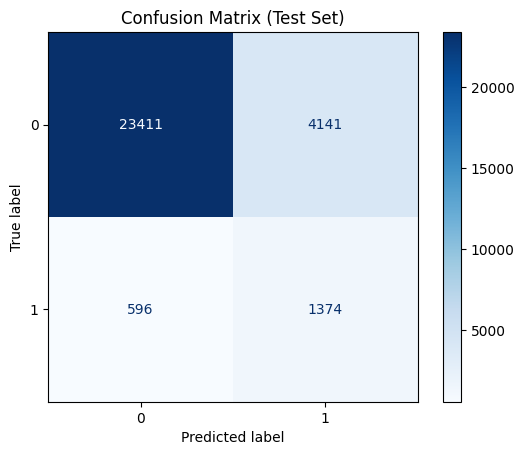

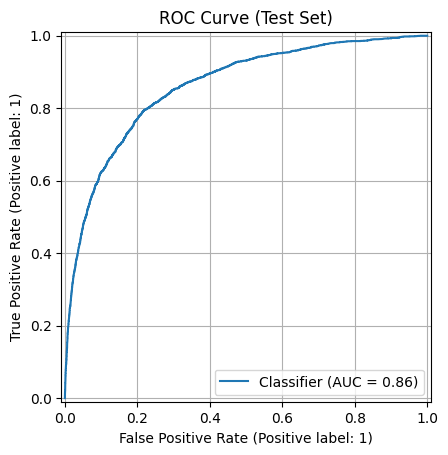

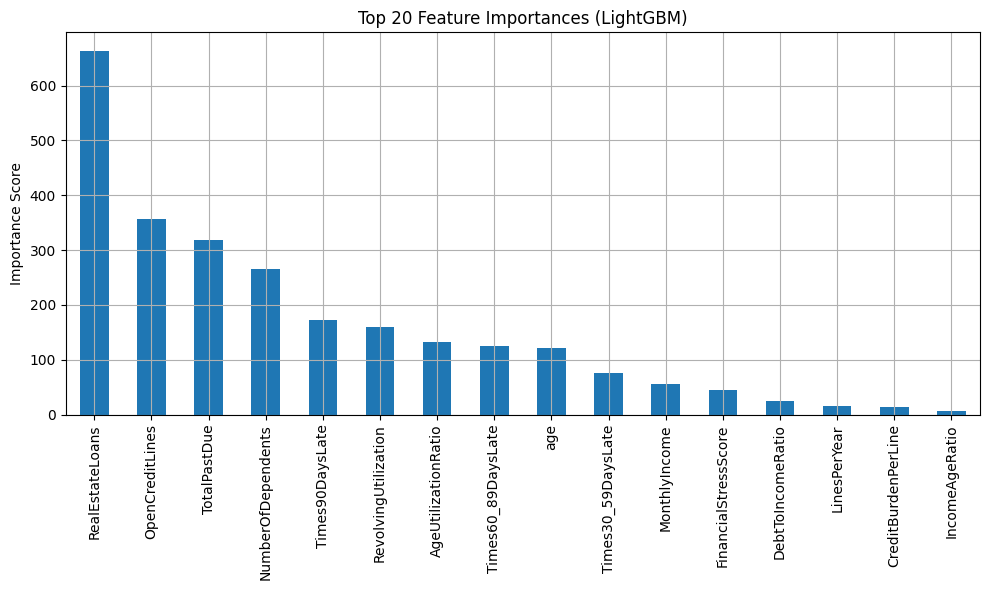

In [26]:
# Predict probabilities on the test set
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Apply the selected threshold
y_test_pred = (y_test_prob >= best_threshold).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob)

print("📊 Final Evaluation on Test Set")
print(f"Threshold     : {best_threshold}")
print(f"AUC           : {auc:.4f}")
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Step 5: Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_test_prob)
plt.title("ROC Curve (Test Set)")
plt.grid(True)
plt.show()

#Feature Importance
importances = best_model.feature_importances_
feature_names = X_test.columns  # Asegúrate de que sea un DataFrame
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (LightGBM)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()


## Results

The final LightGBM model was evaluated on the held-out test set using a custom decision threshold of **0.32**, optimized to prioritize **recall** while maintaining reasonable **precision**. This choice was guided by the business goal of proactively identifying individuals at risk of experiencing financial distress within the next two years.


The **Give Me Some Credit** competition aims to predict financial distress, a task where **recall is more valuable than precision**. In real-world applications, failing to identify someone at risk of default can lead to significant financial losses. On the other hand, incorrectly flagging a customer who is not actually at risk (false positive) may lead to unnecessary interventions but is far less damaging.

- The model achieves a **recall of 70.7%**, correctly identifying the majority of customers who are likely to default.  
- Precision is **24.4%**, meaning that about 1 in 4 flagged customers will actually default. While not ideal, this level of precision is acceptable when the **cost of false negatives outweighs the cost of false positives**.
- An **AUC of 0.86** confirms that the model is capable of distinguishing high-risk customers from low-risk ones across various thresholds.

In [30]:
# 1. Función para transformar probabilidad en score (inversamente proporcional)
def probability_to_score(p, min_score=300, max_score=900):
    return round(max_score - (p * (max_score - min_score)))

# 2. Generar los scores a partir de las probabilidades del test set
scores = [probability_to_score(p) for p in y_test_prob]

# 3. Función opcional para clasificar los scores
def score_category(score):
    if score >= 750:
        return "Excellent"
    elif score >= 700:
        return "Good"
    elif score >= 650:
        return "Fair"
    elif score >= 600:
        return "Poor"
    else:
        return "Very Poor"

# 4. Asignar categoría a cada score
categories = [score_category(s) for s in scores]


score_df.head(10)


,Probability of Default,Simulated Score,Risk Category
0,0.728870,463,Very Poor
1,0.144562,813,Excellent
2,0.212134,773,Excellent
3,0.116843,830,Excellent
4,0.123748,826,Excellent
5,0.154242,807,Excellent
6,0.075577,855,Excellent
7,0.071682,857,Excellent
8,0.081015,851,Excellent
9,0.108269,835,Excellent


In [32]:
score_df["Risk Category"].value_counts()

Risk Category
Excellent    22131
Very Poor     2927
Good          2159
Fair          1456
Poor           849
Name: count, dtype: int64

## Conclusion

The LightGBM model demonstrates strong generalization on unseen data and aligns well with the business objective of **risk mitigation**. By adjusting the decision threshold, the model successfully prioritizes recall to flag most customers at risk of financial distress, making it a valuable tool for deployment in the credit risk simulator.

Despite moderate precision, the model's performance reflects a thoughtful balance between **risk detection** and **customer impact**, supporting informed decision-making in financial services.

In [35]:
import joblib
import os

os.makedirs("../model", exist_ok=True)

joblib.dump(best_model, "../model/best_model.pkl")
joblib.dump(scaler, "../model/scaler.pkl")


['../model/scaler.pkl']